Instalar las siguientes librerias y reiniciar el kernel

In [86]:
%pip install tensorflow
%pip install keras
%pip install --upgrade keras
%pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [87]:
import logging
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from tf_regressor import train_test_split_scale_center

# Estas dos lineas son para silenciar las advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Redes Neuronales

### Laboratorio de Datos, IC - FCEN - UBA - 1er. Cuatrimestre 2024

### 1. Perceptrón Simple : clasificación binaria 

Armaremos una red neuronal para predecir si una persona tiene o no diabetes a partir de 8 caracteristicas:
- Embarazos
- Glucosa
- Presión sanguínea
- Grosor de la piel
- Insulina
- Indice de masa corporal (BMI)
- Antecedentes familiares
- Edad

Como se trata de un problema de clasificación, la función de activación será la función sigmoidea.

In [88]:
# Cargamos el dataset y descartamos las observaciones con campos faltantes
data = pd.read_csv('../../Datos/diabetes.csv')
data.dropna(inplace=True)

# Definimos las variables.
X = data.drop('Outcome', axis=1)    # Queremos todas las columnas salvo Outcome
y = data['Outcome']

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, test_size=0.2, random_state=42)

In [107]:
# En pro de la reproducibilidad, especificamos la semilla para keras
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(8,)),             # Capa de input: indicamos que el input tiene dimension 8
    keras.layers.Dense(1,                       # Capa de output: el output tiene dimension 1 (clasificacion binaria)
                       activation='sigmoid')    # y su funcion de activacion es la sigmoidea.
])

8

In [90]:
# Paso 2: configuramos el optimizador: usaremos Descenso por Gradiente Estocástico con learning rate constante 0.5
# Documentacion SGD : https://keras.io/api/optimizers/sgd/
optimizer = keras.optimizers.SGD(learning_rate=0.5)

In [106]:
# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,            # Optimizador a utilizar
    loss='binary_crossentropy',     # Funcion de perdida para clasificacion binaria
    metrics=['accuracy',            # Metricas a registrar durante el entrenamiento
             'false_negatives']
)

In [92]:
# Paso 4: entrenamiento del modelo.
# model.fit devuelve un objeto History que guarda la evolucion del valor de la funcion de perdida y de las metricas
# luego de cada epoca.
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    # Ingresamos los datos de entrenamiento
                 epochs=150,                                # Especificamos la cantidad de épocas
                 batch_size=20,                             # Especificamos el tamaño del batch
                 validation_split=0.2,                      # 20% de datos para validación
                 verbose=0,                                 # Opcional, para que no muestre el proceso de entrenamiento.
                 )

In [93]:
# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'accuracy': 0.7727272510528564,
 'false_negatives': 20.0,
 'loss': 0.5191484689712524}

In [94]:
# Armamos una funcion para graficar el error a través de las épocas
def graficar_error(history, error_name):
    x_arr = np.array(history.epoch)    # en el atributo epoch, history guarda una lista de epocas
    plot = (
        so.Plot()
        .add(so.Line(color='blue'), x=x_arr, y=history.history[error_name], label='Entrenamiento')
        .add(so.Line(color='orange'), x=x_arr, y=history.history[f'val_{error_name}'], label='Validacion')
        .label(title=error_name)
    )
    plot.show()

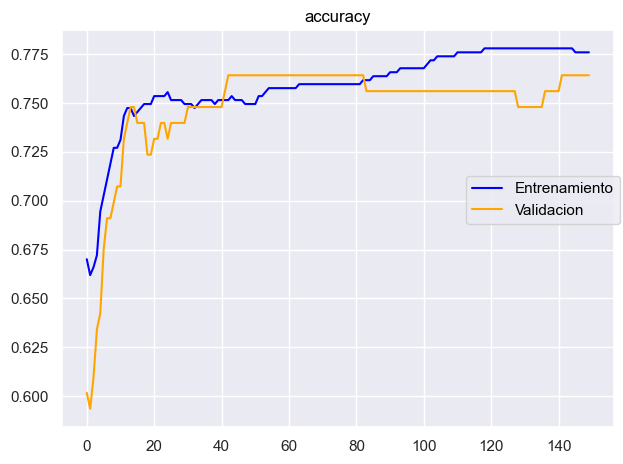

In [95]:
graficar_error(hist, 'accuracy')

Analizando los pesos, podemos interpretar qué factor es más influyente en el diagnóstico de diabetes

In [96]:
# Aqui se guardan los pesos en la primera coordenada y el bias en la segunda
model.weights

# Recuperamos los pesos:
weights = model.weights[0].numpy().flatten()

# Armamos una Serie para simplificar el análisis
pd.Series(weights, index=X_train.columns, name='Peso en la RN')

Pregnancies      0.724379
Glucose          7.082782
BloodPressure   -1.280861
SkinThickness    0.430450
Insulin         -2.261587
BMI              6.150246
Pedigree         1.656113
Age              2.329280
Name: Peso en la RN, dtype: float32

### 2. Perceptrón Simple : clasificación en más de dos categorías

Ahora, dadas las cuatro características de los pingüinos (peso, longitud de aleta y profundidad y longitud del pico), 
intentaremos predecir de qué especie es (Adelie, Chinstrap o Gentoo).

In [97]:
# Cargamos el dataset y descartamos las observaciones con campos faltantes
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Como en el dataset los pinguinos estan ordenados por especie, estaria bueno mezclar el DataFrame
penguins = penguins.sample(len(penguins))

# Definimos las variables.
X = penguins[['bill_length_mm', 'flipper_length_mm', 'bill_depth_mm', 'body_mass_g']]
# Armamos una Serie las etiquetas: 0 corresponde a Gentoo, 1 corresponde a Adelie, 2 corresponde a Chinstrap
y = penguins['species'].apply(lambda x: 1*(x == 'Adelie') + 2*(x == 'Chinstrap'))    

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, test_size=0.2, random_state=21)

In [98]:
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(4,)),             # Capa de input: indicamos que el input tiene dimension 4
    keras.layers.Dense(3,                       # Capa de output: el output tiene dimension 3 (una neurona para cada especie)
                       activation='sigmoid')    # y su funcion de activacion es la sigmoidea.
])

# Paso 2: configuramos el optimizador
optimizer = keras.optimizers.SGD(learning_rate=0.5)

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,                        
    loss='sparse_categorical_crossentropy',     # Funcion de perdida para clasificacion con mas de dos categorias
    metrics=['accuracy']                        
)

# Paso 4: entrenamiento del modelo. 
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    
                 epochs=150,                                 
                 batch_size=20,                             
                 validation_split=0.2,                      
                 verbose=0,                                 
                 )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'accuracy': 0.9552238583564758, 'loss': 0.09110856056213379}

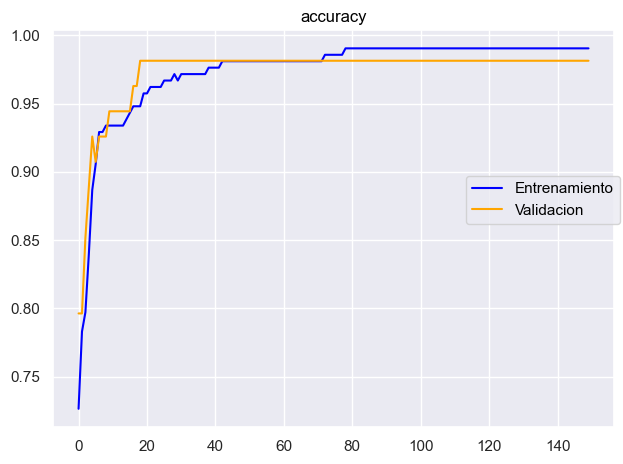

In [99]:
# Graficamos la evolucion de la precision de la clasficiacion
graficar_error(hist, 'accuracy')

### 3. Perceptrón Multicapa

In [100]:
data = pd.read_csv('../../Datos/nutrition.csv')
data.isna().sum()

FDC_ID                0
Item                  0
Category              0
Calorias_kcal         0
Proteinas_g           0
Carbohidratos_g       0
GrasaTotal_g          0
Colesterol_mg       399
Fibra_g             562
Agua_g                0
Alcohol_g          2394
VitaminaC_mg        461
dtype: int64

In [101]:
data.shape

(7793, 12)

In [102]:
data.dropna(inplace=True)
data.columns

Index(['FDC_ID', 'Item', 'Category', 'Calorias_kcal', 'Proteinas_g',
       'Carbohidratos_g', 'GrasaTotal_g', 'Colesterol_mg', 'Fibra_g', 'Agua_g',
       'Alcohol_g', 'VitaminaC_mg'],
      dtype='object')

In [103]:
X = data.drop(columns=['FDC_ID', 'Item', 'Category', 'Calorias_kcal'])
y = data['Calorias_kcal']

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, transform_y=True, test_size=0.2, random_state=21)

In [104]:
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)), 
    keras.layers.Dense(4,                       
                       activation='sigmoid'),
    keras.layers.Dense(1,                       
                       activation='sigmoid')    
])

# Paso 2: configuramos el optimizador
optimizer = keras.optimizers.SGD(learning_rate=0.5)

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,                        
    loss='mean_squared_error',                    
)

# Paso 4: entrenamiento del modelo. 
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    
                 epochs=100,                                 
                 batch_size=20,                             
                 validation_split=0.2,                      
                 verbose=0,                                 
                 )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'loss': 0.0011638907017186284}

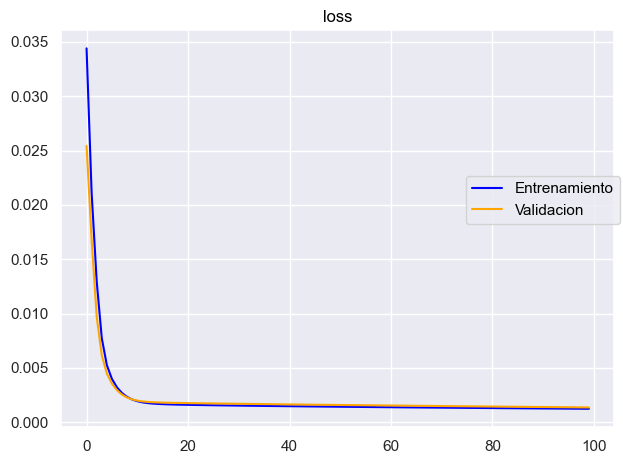

In [105]:
graficar_error(hist, 'loss')